In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from util.dataset import AnomalyDataset
from datetime import datetime

from module.conv_ae import ConvAEUPSC

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         ])

p = '/home/jieun/Documents/machine_vision/data'
trainset = AnomalyDataset(flag='CIFAR10', dp=p, train=True, transform=transform)
testset = AnomalyDataset(flag='CIFAR10', dp=p, train=False, transform=transform)
    
train_len, test_len = len(trainset), len(testset)

train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

learning_rate = 1e-3

autoencoder = ConvAEUPSC()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

ConvAEUPSC(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(size=(8, 8), mode=nearest)
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(size=(16, 16), mode=nearest)
    (4): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Upsample(size=(32, 32), mode=nearest)
    (7): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
  )
)

In [5]:
total_iter = 0
start = datetime.now()
losses = list()
epochs = 50

# TRAIN
for epoch in range(epochs):
    print('\n===> epoch %d' % epoch)

    running_loss = 0
    n_iter = 0

    for idx, data in enumerate(train_loader, 0):
        # 순전파 단계: 모델에 x를 전달하여 예상하는 y 값을 계산합니다.
        images, _ = data[:2]
        n_data = images.shape[0]
        # images = images.view(n_data, -1)

        images = images.to(device)

        y_pred = autoencoder(images)

        # 손실을 계산하고 출력합니다.
        # loss = PairwiseDistance(2).forward(y_pred, images)
        loss = criterion(y_pred, images)
        losses.append(torch.mean(loss))

        # 변화도를 0으로 만들고, 역전파 단계를 수행하고, 가중치를 갱신합니다.
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
        total_iter += 1
        n_iter += 1

        running_loss += torch.mean(loss)

    epoch_loss = running_loss / n_iter
    print("{} epoch, takes {}, loss: {:.10f}".format(epoch, str(datetime.now() - start), epoch_loss))


===> epoch 0
0 epoch, takes 0:00:02.184003, loss: 0.0395310633

===> epoch 1
1 epoch, takes 0:00:04.148035, loss: 0.0153268557

===> epoch 2
2 epoch, takes 0:00:06.072062, loss: 0.0134372842

===> epoch 3
3 epoch, takes 0:00:07.990277, loss: 0.0128963776

===> epoch 4
4 epoch, takes 0:00:09.943571, loss: 0.0185786076

===> epoch 5
5 epoch, takes 0:00:11.901142, loss: 0.0133497445

===> epoch 6
6 epoch, takes 0:00:13.789843, loss: 0.0122209741

===> epoch 7
7 epoch, takes 0:00:15.747849, loss: 0.0126037914

===> epoch 8
8 epoch, takes 0:00:17.681605, loss: 0.0122791277

===> epoch 9
9 epoch, takes 0:00:19.615901, loss: 0.0117824376

===> epoch 10
10 epoch, takes 0:00:21.566115, loss: 0.0114131700

===> epoch 11
11 epoch, takes 0:00:23.524440, loss: 0.0112797525

===> epoch 12
12 epoch, takes 0:00:25.496943, loss: 0.0112209953

===> epoch 13
13 epoch, takes 0:00:27.429224, loss: 0.0112552103

===> epoch 14
14 epoch, takes 0:00:29.388005, loss: 0.0112696784

===> epoch 15
15 epoch, takes

TRAIN DATASET


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


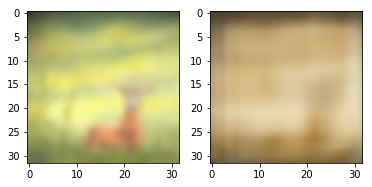

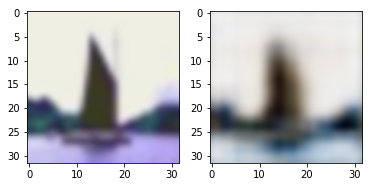

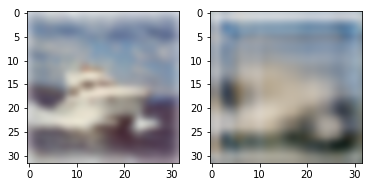

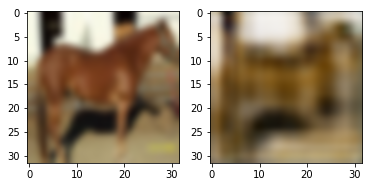

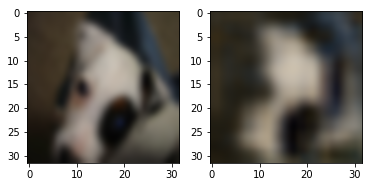

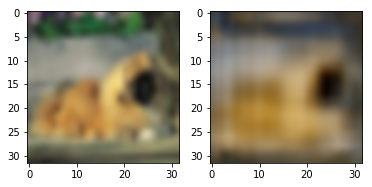

TEST DATASET


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


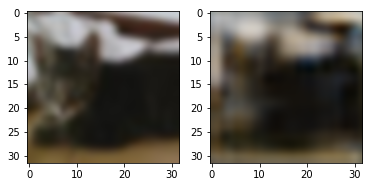

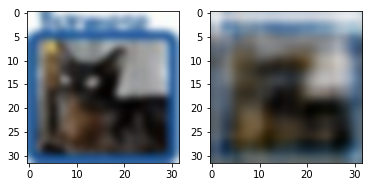

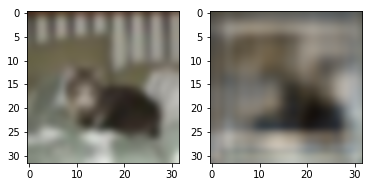

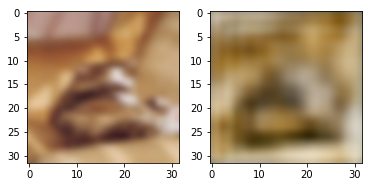

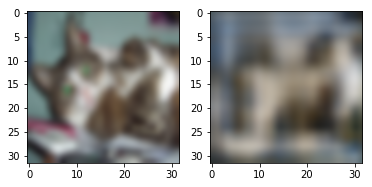

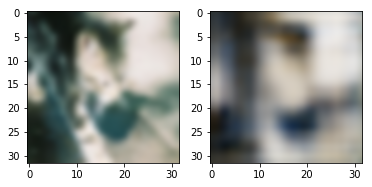

In [6]:
# TEST
reconstuction_error = list()
total_labels = [1] * train_len + [0] * test_len

print('TRAIN DATASET')
for idx, data in enumerate(train_loader, 0):
    images, _ = data[:2]
    input_images = images.to(device)

    y_pred = autoencoder(input_images)

    pic = y_pred.cpu().view(-1, 3, 32, 32).detach().numpy().transpose((0, 2, 3, 1))
    if idx <= 5:
        fig = plt.figure()
        fig.add_subplot(1, 2, 1)
        plt.imshow(transforms.ToPILImage()(images[0]), interpolation='bicubic')
        fig.add_subplot(1, 2, 2)
        plt.imshow(pic[0], interpolation='bicubic')

#         plt.savefig('/home/jieun/Documents/machine_vision/imgs/{}.png'.format('conv_ae_normal' + str(idx)))

    sub_reconstuction_error = list()
    for i in range(len(y_pred)):
        sub_reconstuction_error.append(torch.dist(input_images[i], y_pred[i]).item())
    reconstuction_error.extend(sub_reconstuction_error)

plt.show()
print('TEST DATASET')
for idx, data in enumerate(test_loader, 0):
    images, _ = data[:2]
    input_images = images.to(device)

    y_pred = autoencoder(input_images)

    pic = y_pred.cpu().view(-1, 3, 32, 32).detach().numpy().transpose((0, 2, 3, 1))
    if idx <= 5:
        fig = plt.figure()
        fig.add_subplot(1, 2, 1)
        plt.imshow(transforms.ToPILImage()(images[0]), interpolation='bicubic')
        fig.add_subplot(1, 2, 2)
        plt.imshow(pic[0], interpolation='bicubic')

#         plt.savefig('/home/jieun/Documents/machine_vision/imgs/{}.png'.format('conv_ae_anomaly'+str(idx)))
        # plt.show()

    sub_reconstuction_error = list()
    for i in range(len(y_pred)):
        sub_reconstuction_error.append(torch.dist(input_images[i], y_pred[i]).item())

    reconstuction_error.extend(sub_reconstuction_error)

di = {'total_label': total_labels, 'reconstuction_error': reconstuction_error}


In [7]:
from util.validation import plot_re

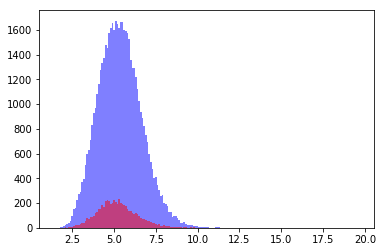

In [8]:
# plot the distribution of reconstruction error for each train(normal), test(anomaly)
plot_re('', data=di)